In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from math import cos, asin, sqrt
import matplotlib.pyplot as plt
import numpy as np
import pickle
import math
import xarray as xr
import netCDF4 as nc
from matplotlib import ticker, cm
from matplotlib import animation, rc
import matplotlib.tri as tri
import sys
#import metpy.calc as mpcalc
#from metpy.cbook import get_test_data
#from metpy.interpolate import cross_section
import scipy.ndimage as ndimage
from mpl_toolkits.axes_grid1 import make_axes_locatable
sys.setrecursionlimit(9000)
import scipy.ndimage
import statistics
import scipy.io
import h5py
from scipy.interpolate import griddata

In [2]:
SP_Case = 'SP_newsst_long_L125_ERA5_2008_F-MMF1_frontera_ne16pg2_r05_oQU240_CRM1_32_x_120z1200m.5s_crm_nx_rad_16_np_768_nlev_125.frontera'
SP_PATH = '/media/liran/Liran_Data6/SP/'
SP2008 = xr.open_mfdataset(SP_PATH+SP_Case+'.cam.h0.*.nc')
UP_Case = 'UP_newsst_long_L125_ERA5_2008_F-MMF1_frontera_ne16pg2_r05_oQU240_CRM1_64_x_120z200m.0.5s_crm_nx_rad_16_np_768_nlev_125.frontera'
UP_PATH = '/media/liran/PLR5/Frontera_newSSTruns/UP/'
UP2008 = xr.open_mfdataset(UP_PATH+UP_Case+'.cam.h0.2008-10-*.nc')
UPsedi12_PATH = '/media/liran/PLR5/Frontera_newSSTruns/UPhysedi12/'
UPhysedi12 = xr.open_mfdataset(UPsedi12_PATH+'HPhyper_sedi12_long_newsst_L125_ERA5_2008_F-MMF1_frontera_ne16pg2_r05_oQU240_CRM1_64_x_120z200m.0.5s_crm_nx_rad_16_np_768_nlev_125.frontera.cam.h0.*.nc')
UPsedi15_PATH = '/media/liran/PLR5/Frontera_newSSTruns/UPhysedi15/'
UPhysedi15 = xr.open_mfdataset(UPsedi15_PATH+'HPhyper_sedi15_long_newsst_L125_ERA5_2008_F-MMF1_frontera_ne16pg2_r05_oQU240_CRM1_64_x_120z200m.0.5s_crm_nx_rad_16_np_768_nlev_125.frontera.cam.h0.*.nc')
UPsedi17_PATH = '/media/liran/PLR5/Frontera_newSSTruns/UPhysedi17/'
UPhysedi17 = xr.open_mfdataset(UPsedi17_PATH+'HPhyper_sedi17_long_newsst_L125_ERA5_2008_F-MMF1_frontera_ne16pg2_r05_oQU240_CRM1_64_x_120z200m.0.5s_crm_nx_rad_16_np_768_nlev_125.frontera.cam.h0.*.nc')
UPhy_PATH = '/media/liran/PLR5/Frontera_newSSTruns/UPhy/'
UPhy2008 = xr.open_mfdataset(UPhy_PATH+'HPhyper_newsst_L125_ERA5_2008_F-MMF1_frontera_ne16pg2_r05_oQU240_CRM1_64_x_120z200m.0.5s_crm_nx_rad_16_np_768_nlev_125.frontera.cam.h0.2008-10-*.nc')

In [16]:
CERES_PATH = '/media/liran/Elements/CERES/'
count = 0
ndays = 15
sDay = 1
iy = 2008
CERES_FAME = 'CERES_SYN1deg-Day_Terra-Aqua-MODIS_Ed4.1_Subset_'+str(iy)+'1001-'+str(iy)+'1130.nc'
CERES_FILE = nc.Dataset(CERES_PATH+CERES_FAME, mode = 'r')
toa_sw_all_daily = CERES_FILE.variables['toa_sw_all_daily']
toa_lw_all_daily = CERES_FILE.variables['toa_lw_all_daily']
toa_solar_all_daily = CERES_FILE.variables['toa_solar_all_daily']
if count ==0: 
    fsntoa_obs      = toa_solar_all_daily[sDay-1:sDay-1+ndays,:,:]-toa_sw_all_daily[sDay-1:sDay-1+ndays,:,:]
    toa_lw_obs      = toa_lw_all_daily[sDay-1:sDay-1+ndays,:,:]
else:
    work1           = toa_solar_all_daily[sDay-1:sDay-1+ndays,:,:]-toa_sw_all_daily[sDay-1:sDay-1+ndays,:,:]
    work2           = toa_lw_all_daily[sDay-1:sDay-1+ndays,:,:]
    fsntoa_obs      = fsntoa_obs+work1
    toa_lw_obs      = toa_lw_obs+work2
print(count)
fsntoa_obs = fsntoa_obs
toa_lw_obs = toa_lw_obs
fsntoa_obs_mean = np.mean(fsntoa_obs, axis=0)
toa_lw_obs_mean = np.mean(toa_lw_obs, axis=0)
# Read coordinates
lon_CERES  = CERES_FILE.variables['lon'] # 360
lat_CERES  = CERES_FILE.variables['lat'] # 180
time_CERES = CERES_FILE.variables['time']

0


/home/liran/.local/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  if sys.path[0] == '':
/home/liran/.local/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  if sys.path[0] == '':
/home/liran/.local/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  del sys.path[0]
/home/liran/.local/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  del sys.path[0]


In [10]:
# Read coordinates
lon = SP2008.lon.isel(time=0).values
lat = SP2008.lat.isel(time=0).values
Z3 = SP2008.Z3.isel(time=0).values
points6 = np.zeros([6144, 2])
points6[:,0] = lon
points6[:,1] = lat
xi = lon_CERES[:]
yi = lat_CERES[:]
Xi, Yi = np.meshgrid(lon_CERES, lat_CERES)

In [17]:
hstart = 1
#hend   = 1009
hend   = 2161
UP_Ensemble    = np.zeros([1,6144])
SP_Ensemble    = np.zeros([1,6144])
UPhy_Ensemble  = np.zeros([1,6144])
UPhys15_Ensemble  = np.zeros([1,6144])
UPhys17_Ensemble  = np.zeros([1,6144])
UPhys12_Ensemble  = np.zeros([1,6144])

UP_Ensemble_ASR    = np.zeros([1,6144])
SP_Ensemble_ASR    = np.zeros([1,6144])
UPhy_Ensemble_ASR  = np.zeros([1,6144])
UPhys15_Ensemble_ASR  = np.zeros([1,6144])
UPhys17_Ensemble_ASR  = np.zeros([1,6144])
UPhys12_Ensemble_ASR  = np.zeros([1,6144])

UP2008_FSNTOA                 = UP2008.variables['FSNTOA'] 
SP2008_FSNTOA                 = SP2008.variables['FSNTOA'] 
UPhy2008_FSNTOA               = UPhy2008.variables['FSNTOA'] 
UPhys15_2008_FSNTOA           = UPhysedi15.variables['FSNTOA']
UPhys17_2008_FSNTOA           = UPhysedi17.variables['FSNTOA']
UPhys12_2008_FSNTOA           = UPhysedi12.variables['FSNTOA']
UP_Ensemble[0,:] = np.mean(UP2008_FSNTOA[hstart-1:hend-1,:], axis=0)
SP_Ensemble[0,:] = np.mean(SP2008_FSNTOA[hstart-1:hend-1,:], axis=0)
UPhy_Ensemble[0,:] = np.mean(UPhy2008_FSNTOA[hstart-1:hend-1,:], axis=0)
UPhys15_Ensemble[0,:] = np.mean(UPhys15_2008_FSNTOA[hstart-1:hend-1,:], axis=0)
UPhys17_Ensemble[0,:] = np.mean(UPhys17_2008_FSNTOA[hstart-1:hend-1,:], axis=0)
UPhys12_Ensemble[0,:] = np.mean(UPhys12_2008_FSNTOA[hstart-1:hend-1,:], axis=0)
UP2008_SOLIN                 = UP2008.variables['SOLIN'] 
SP2008_SOLIN                 = SP2008.variables['SOLIN'] 
UPhy2008_SOLIN               = UPhy2008.variables['SOLIN'] 
UPhys15_2008_SOLIN           = UPhysedi15.variables['SOLIN']
UPhys17_2008_SOLIN           = UPhysedi17.variables['SOLIN']
UPhys12_2008_SOLIN           = UPhysedi12.variables['SOLIN']

## Peter suggest
- In the folder, you had plots of FLNT (= OLR) which could be compared to the CERES data averaged over the same regions.  Similarly, I would suggest comparing ASR=SOLIN-FSNTOA from the model with ASR=toa_solar_all_1h-toa_sw_all_1h from CERES.

In [18]:
UP_Ensemble_ASR[0,:] = np.mean(UP2008_SOLIN[hstart-1:hend-1,:], axis=0)-UP_Ensemble[0,:]
SP_Ensemble_ASR[0,:] = np.mean(SP2008_SOLIN[hstart-1:hend-1,:], axis=0)-SP_Ensemble[0,:]
UPhy_Ensemble_ASR[0,:] = np.mean(UPhy2008_SOLIN[hstart-1:hend-1,:], axis=0)-UPhy_Ensemble[0,:]
UPhys15_Ensemble_ASR[0,:] = np.mean(UPhys15_2008_SOLIN[:,:], axis=0)-UPhys15_Ensemble[0,:]
UPhys17_Ensemble_ASR[0,:] = np.mean(UPhys17_2008_SOLIN[:,:], axis=0)-UPhys17_Ensemble[0,:]
UPhys12_Ensemble_ASR[0,:] = np.mean(UPhys12_2008_SOLIN[:,:], axis=0)-UPhys12_2008_FSNTOA[0,:]

In [19]:
 #<<<<<<<<
UPFSNTOA_Ensemble_standard        = np.mean(UP_Ensemble, axis=0)
SPFSNTOA_Ensemble_standard        = np.mean(SP_Ensemble, axis=0)
UPhyFSNTOA_Ensemble_standard      = np.mean(UPhy_Ensemble, axis=0)
UPhys15_Ensemble_standard     = np.mean(UPhys15_Ensemble, axis=0)
UPhys17_Ensemble_standard     = np.mean(UPhys17_Ensemble, axis=0)
UPhys12_Ensemble_standard     = np.mean(UPhys12_Ensemble, axis=0)
UPFSNTOA_Ensemble_standardi  = griddata(points6,UPFSNTOA_Ensemble_standard[:], (Xi, Yi), method='nearest')
SPFSNTOA_Ensemble_standardi  = griddata(points6,SPFSNTOA_Ensemble_standard[:], (Xi, Yi), method='nearest')
UPhyFSNTOA_Ensemble_standardi  = griddata(points6,UPhyFSNTOA_Ensemble_standard[:], (Xi, Yi), method='nearest')
UPhys15_Ensemble_standardi  = griddata(points6,UPhys15_Ensemble_standard[:], (Xi, Yi), method='nearest')
UPhys17_Ensemble_standardi  = griddata(points6,UPhys17_Ensemble_standard[:], (Xi, Yi), method='nearest')
UPhys12_Ensemble_standardi  = griddata(points6,UPhys12_Ensemble_standard[:], (Xi, Yi), method='nearest')

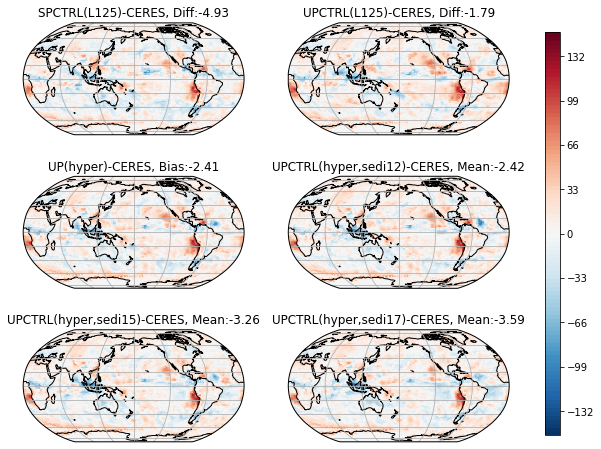

In [20]:
# Compare the Low cloud fraction
#xi = lon_ERA5[:]+180
#yi = lat_ERA5[:]
xi = lon_CERES[:]+180
yi = lat_CERES[:]
#-- create figure and axes object
fig = plt.figure(figsize=(10,8))
levels = np.linspace(0, 1, 101)
levels2 = np.linspace(-150.0, 150.0, 101)
levels3 = np.linspace(-60,60, 101)
# --------------------
ax2 = fig.add_subplot(3,2,1, projection=ccrs.Robinson(central_longitude=180.0))
ax2.coastlines()
ax2.gridlines()
cntr2=ax2.contourf(xi, yi, SPFSNTOA_Ensemble_standardi[:,:]-fsntoa_obs_mean[:,:], levels=levels2, cmap="RdBu_r",transform=ccrs.PlateCarree(central_longitude=180.0))
#cb2 = fig.colorbar(cntr2, ax=ax2,orientation = 'horizontal')
tick_locator = ticker.MaxNLocator(nbins = 9)
cb2.locator = tick_locator
cb2.update_ticks()
title2 = 'SPCTRL(L125)-CERES, Diff:'+'{:.2f}'
ax2.set_title(title2.format(np.mean(SPFSNTOA_Ensemble_standardi[:,:]-fsntoa_obs_mean[:,:])))
# --------------------
ax2 = fig.add_subplot(3,2,2, projection=ccrs.Robinson(central_longitude=180.0))
ax2.coastlines()
ax2.gridlines()
cntr2=ax2.contourf(xi, yi, UPFSNTOA_Ensemble_standardi[:,:]-fsntoa_obs_mean[:,:], levels=levels2, cmap="RdBu_r",transform=ccrs.PlateCarree(central_longitude=180.0))
#cb2 = fig.colorbar(cntr2, ax=ax2,orientation = 'horizontal')
tick_locator = ticker.MaxNLocator(nbins = 9)
cb2.locator = tick_locator
cb2.update_ticks()
title2 = 'UPCTRL(L125)-CERES, Diff:'+'{:.2f}'
ax2.set_title(title2.format(np.mean(UPFSNTOA_Ensemble_standardi[:,:]-fsntoa_obs_mean[:,:])))
# --------------------
ax6 = fig.add_subplot(3,2,3, projection=ccrs.Robinson(central_longitude=180.0))
ax6.coastlines()
ax6.gridlines()
cntr6=ax6.contourf(xi, yi, UPhyFSNTOA_Ensemble_standardi[:,:]-fsntoa_obs_mean[:,:], levels=levels2, cmap="RdBu_r",transform=ccrs.PlateCarree(central_longitude=180.0))
#cb6 = fig.colorbar(cntr6, ax=ax6,orientation = 'horizontal')
tick_locator = ticker.MaxNLocator(nbins = 9)
cb6.locator = tick_locator
cb6.update_ticks()
title6 = 'UP(hyper)-CERES, Bias:'+'{:.2f}'
ax6.set_title(title6.format(np.mean(UPhyFSNTOA_Ensemble_standardi[:,:]-fsntoa_obs_mean[:,:])))
# --------------------
ax55 = fig.add_subplot(3,2,4, projection=ccrs.Robinson(central_longitude=180.0))
ax55.set_global()
#-- add coastlines, country border lines, and grid lines
ax55.coastlines()
ax55.gridlines()
cntr55=ax55.contourf(xi, yi, UPhys12_Ensemble_standardi[:,:]-fsntoa_obs_mean[:,:], levels=levels2, cmap="RdBu_r",transform=ccrs.PlateCarree(central_longitude=180.0))
#cb55 = fig.colorbar(cntr55, ax=ax55,orientation = 'horizontal')
tick_locator = ticker.MaxNLocator(nbins = 9)
cb55.locator = tick_locator
cb55.update_ticks()
#ax55.plot([lon_CERES[minindexlon1],lon_CERES[minindexlon2]],[lat_CERES[minindexlat1],lat_CERES[minindexlat2]],transform=ccrs.PlateCarree())
#ax55.plot([lon_CERES[minindexlon1],lon_CERES[minindexlon3]],[lat_CERES[minindexlat1],lat_CERES[minindexlat3]],transform=ccrs.PlateCarree())
#ax55.plot([lon_CERES[minindexlon2],lon_CERES[minindexlon4]],[lat_CERES[minindexlat2],lat_CERES[minindexlat4]],transform=ccrs.PlateCarree())
#ax55.plot([lon_CERES[minindexlon3],lon_CERES[minindexlon4]],[lat_CERES[minindexlat3],lat_CERES[minindexlat4]],transform=ccrs.PlateCarree())
title55 = 'UPCTRL(hyper,sedi12)-CERES, Mean:'+'{:.2f}'
ax55.set_title(title55.format(np.mean(UPhys12_Ensemble_standardi[:,:]-fsntoa_obs_mean[:,:])))

# --------------------
ax55 = fig.add_subplot(3,2,6, projection=ccrs.Robinson(central_longitude=180.0))
ax55.set_global()
#-- add coastlines, country border lines, and grid lines
ax55.coastlines()
ax55.gridlines()
cntr55=ax55.contourf(xi, yi, UPhys17_Ensemble_standardi[:,:]-fsntoa_obs_mean[:,:], levels=levels2, cmap="RdBu_r",transform=ccrs.PlateCarree(central_longitude=180.0))
#cb55 = fig.colorbar(cntr55, ax=ax55,orientation = 'horizontal')
tick_locator = ticker.MaxNLocator(nbins = 9)
cb55.locator = tick_locator
cb55.update_ticks()
title55 = 'UPCTRL(hyper,sedi17)-CERES, Mean:'+'{:.2f}'
ax55.set_title(title55.format(np.mean(UPhys17_Ensemble_standardi[:,:]-fsntoa_obs_mean[:,:])))

# --------------------
ax551 = fig.add_subplot(3,2,5, projection=ccrs.Robinson(central_longitude=180.0))
ax551.set_global()
#-- add coastlines, country border lines, and grid lines
ax551.coastlines()
ax551.gridlines()
cntr551=ax551.contourf(xi, yi, UPhys15_Ensemble_standardi[:,:]-fsntoa_obs_mean[:,:], levels=levels2, cmap="RdBu_r",transform=ccrs.PlateCarree(central_longitude=180.0))
#cb551 = fig.colorbar(cntr551, ax=ax551,orientation = 'horizontal')
tick_locator = ticker.MaxNLocator(nbins = 9)
cb551.locator = tick_locator
cb551.update_ticks()
title551 = 'UPCTRL(hyper,sedi15)-CERES, Mean:'+'{:.2f}'
ax551.set_title(title551.format(np.mean(UPhys15_Ensemble_standardi[:,:]-fsntoa_obs_mean[:,:])))

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(cntr551, cax=cbar_ax)

plt.savefig('2008_SOLIN_minus_FSNTOAdiffCERES_hypersedi_day0To15.png')

plt.show()